In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define Gaussian function
def gaussian(x, A, mu, sigma, offset):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset

# Read CSV data
df = pd.read_csv("data.csv")

color_map = {
    "Red": ("Red:Wavelength(nm)", "Red:Intensity"),
    "Blue": ("Blue:Wavelength(nm)", "Blue:Intensity"),
    "Orange": ("Orange:Wavelength(nm)", "Orange:Intensity"),
    "Yellow": ("Yellow:Wavelength(nm)", "Yellow:Intensity"),
    "Green": ("Green:Wavelength(nm)", "Green:Intensity")
}

results = {}

for color, (wavelength_col, intensity_col) in color_map.items():
    x = df[wavelength_col].dropna().values
    y = df[intensity_col].dropna().values

    # Initial guesses for Gaussian parameters
    A_guess = np.max(y) - np.min(y)
    mu_guess = x[np.argmax(y)]
    sigma_guess = 5.0
    offset_guess = np.min(y)

    try:
        popt, pcov = curve_fit(gaussian, x, y, p0=[A_guess, mu_guess, sigma_guess, offset_guess])
        A, mu, sigma, offset = popt
        perr = np.sqrt(np.diag(pcov))

        results[color] = {
            "lambda_max (nm)": mu,
            "uncertainty (σ, nm)": sigma,
            "fit_error_mu (nm)": perr[1],
            "fit_error_sigma (nm)": perr[2]
        }

        # Plot spectrum and fit
        x_fit = np.linspace(min(x), max(x), 500)
        y_fit = gaussian(x_fit, *popt)
#         plt.plot(x, y, 'o', label=f"{color} data")
#         plt.plot(x_fit, y_fit, '-', label=f"{color} fit (μ={mu:.2f}±{perr[1]:.2f}, σ={sigma:.2f}±{perr[2]:.2f})")

    except RuntimeError:
        print(f"Gaussian fit failed for {color}.")

# plt.xlabel("Wavelength (nm)")
# plt.ylabel("Intensity (a.u.)")
# plt.title("Gaussian Fits of Emission Peaks")
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()

# Print results
for color, vals in results.items():
    print(f"{color}: λ_max = {vals['lambda_max (nm)']:.2f} ± {vals['fit_error_mu (nm)']:.2f} nm, "
          f"σ = {vals['uncertainty (σ, nm)']:.2f} ± {vals['fit_error_sigma (nm)']:.2f} nm")


Red: λ_max = 645.79 ± 0.20 nm, σ = 10.18 ± 0.21 nm
Blue: λ_max = 459.02 ± 0.05 nm, σ = 9.53 ± 0.05 nm
Orange: λ_max = 608.71 ± 0.06 nm, σ = 8.03 ± 0.06 nm
Yellow: λ_max = 589.81 ± 0.10 nm, σ = 7.58 ± 0.10 nm
Green: λ_max = 571.56 ± 0.11 nm, σ = 9.62 ± 0.11 nm


In [2]:
# results

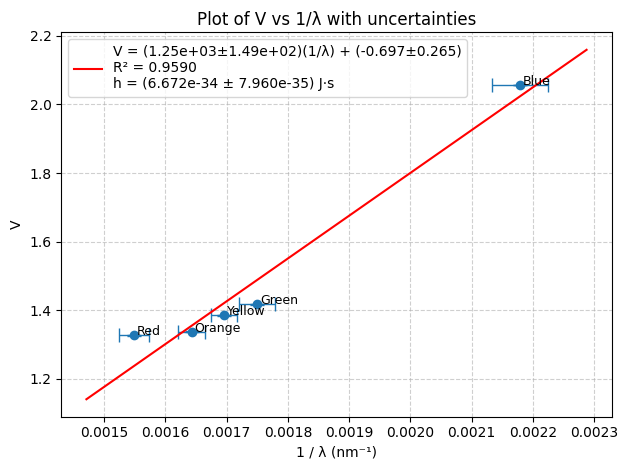

In [3]:
# Data from your table
colors = ["Red", "Blue", "Orange", "Yellow", "Green"]
V = np.array([1.327, 2.057, 1.337, 1.385, 1.417])
V_err = np.array([0.001, 0.001, 0.001, 0.001, 0.001])
lambda_nm = []
lambda_unc = []
for color in colors:
    lambda_nm.append(results[color]["lambda_max (nm)"])
    lambda_unc.append(results[color]["uncertainty (σ, nm)"])
lambda_nm = np.array(lambda_nm)
lambda_unc = np.array(lambda_unc)

# Calculate 1/lambda and its uncertainty
inv_lambda = 1 / lambda_nm
inv_lambda_unc = lambda_unc / (lambda_nm**2)

# Define linear function for fitting
def linear(x, m, b):
    return m * x + b

# Perform weighted fit using uncertainties in V
popt, pcov = curve_fit(linear, inv_lambda, V, sigma=V_err, absolute_sigma=False)
m, b = popt
m_err, b_err = np.sqrt(np.diag(pcov))

# Goodness of fit (R^2)
residuals = V - linear(inv_lambda, m, b)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((V - np.mean(V))**2)
R2 = 1 - (ss_res / ss_tot)

c = 299792458     
e = 1.602e-19      

m_SI = m * 1e-9
m_SI_err = m_err * 1e-9

h = m_SI * e / c
h_err = m_SI_err * e / c

x_fit = np.linspace(min(inv_lambda)*0.95, max(inv_lambda)*1.05, 200)
y_fit = linear(x_fit, m, b)

plt.errorbar(inv_lambda, V, xerr=inv_lambda_unc, yerr=V_err,
             fmt='o', capsize=5, elinewidth=1, markeredgewidth=1)

plt.plot(x_fit, y_fit, 'r-', label=(
    f"V = ({m:.2e}±{m_err:.2e})(1/λ) + ({b:.3f}±{b_err:.3f})\n"
    f"R² = {R2:.4f}\n"
    f"h = ({h:.3e} ± {h_err:.3e}) J·s"
))

for i, color in enumerate(colors):
    plt.text(inv_lambda[i] + 0.000005, V[i], color, fontsize=9)

plt.xlabel("1 / λ (nm⁻¹)")
plt.ylabel("V")
plt.title("Plot of V vs 1/λ with uncertainties")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()